In [85]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

In [32]:
face_cascade = cv2.CascadeClassifier('opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('opencv/haarcascades/haarcascade_eye.xml')

# This function returns a cropped image given a full image path

In [33]:
def get_cropped_image(image_path):
    image = cv2.imread(image_path)
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_image = image[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) == 2:
#             for (ex, ey, ew, eh) in eyes:
#                 cv2.rectangle(roi_image, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
            return roi_image

# Below code is to save all the cropped images

In [34]:
path_to_original_dataset = "./dataset/original/"
path_to_cropped_dataset = "./dataset/cropped/"

In [35]:
import os
import shutil
name_to_path_dict = {}
# cropped_img_dirs = []
if os.path.exists(path_to_cropped_dataset):
    shutil.rmtree(path_to_cropped_dataset)
os.mkdir(path_to_cropped_dataset)

In [36]:
img_dirs = []
for entry in os.scandir(path_to_original_dataset):
    img_dirs.append(entry.path)

In [37]:
for img_dir in img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    
    name_to_path_dict[celebrity_name] = []
    
    cropped_name_folder = path_to_cropped_dataset + celebrity_name + '/'
    os.mkdir(cropped_name_folder)
    
    i = 1
    for entry in os.scandir(img_dir):
        cropped_img = get_cropped_image(entry.path)
        
        if cropped_img is not None:
            cropped_img_path = cropped_name_folder + str(i) + ".jpg"
            cv2.imwrite(cropped_img_path, cropped_img)
            name_to_path_dict[celebrity_name].append(cropped_img_path)
            i += 1


In [38]:
name_to_path_dict

{'lionel_messi': ['./dataset/cropped/lionel_messi/1.jpg',
  './dataset/cropped/lionel_messi/2.jpg',
  './dataset/cropped/lionel_messi/3.jpg',
  './dataset/cropped/lionel_messi/4.jpg',
  './dataset/cropped/lionel_messi/5.jpg',
  './dataset/cropped/lionel_messi/6.jpg',
  './dataset/cropped/lionel_messi/7.jpg',
  './dataset/cropped/lionel_messi/8.jpg',
  './dataset/cropped/lionel_messi/9.jpg',
  './dataset/cropped/lionel_messi/10.jpg',
  './dataset/cropped/lionel_messi/11.jpg',
  './dataset/cropped/lionel_messi/12.jpg',
  './dataset/cropped/lionel_messi/13.jpg',
  './dataset/cropped/lionel_messi/14.jpg',
  './dataset/cropped/lionel_messi/15.jpg'],
 'virat_kohli': ['./dataset/cropped/virat_kohli/1.jpg',
  './dataset/cropped/virat_kohli/2.jpg',
  './dataset/cropped/virat_kohli/3.jpg',
  './dataset/cropped/virat_kohli/4.jpg',
  './dataset/cropped/virat_kohli/5.jpg',
  './dataset/cropped/virat_kohli/6.jpg',
  './dataset/cropped/virat_kohli/7.jpg',
  './dataset/cropped/virat_kohli/8.jpg',
  '.

# Data Preprocessing

#### Wavelet Transformation to extract features from cropped image

In [39]:
import pywt

def w2d(img, mode="haar", level=1):
    imArray = img
    
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    
    imArray = np.float32(imArray)
    imArray /= 255
    
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;

    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

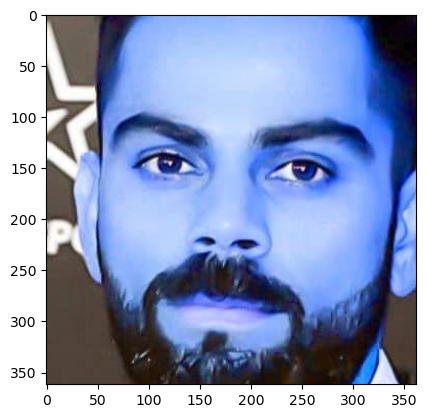

In [40]:
sample_img_path = name_to_path_dict["virat_kohli"][0]
sample_img = cv2.imread(sample_img_path)
plt.imshow(sample_img)

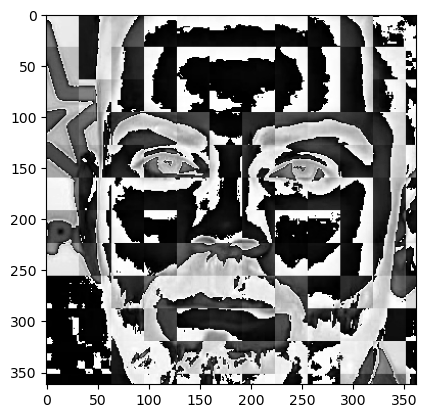

In [41]:
im_har = w2d(sample_img, 'db1', 5)
plt.imshow(im_har, cmap='gray')

# Creating X and y

In [42]:
class_dictionary = {}
count = 0
for celebrety_name in name_to_path_dict.keys():
    class_dictionary[celebrety_name] = count
    count += 1
class_dictionary

{'lionel_messi': 0, 'virat_kohli': 1}

In [48]:
X = []
y = []
for celebrity_name, training_files in name_to_path_dict.items():
    for training_img in training_files:
        raw_image = cv2.imread(training_img)
        if raw_image is None:
            continue
        scalled_raw_image = cv2.resize(raw_image, (32, 32))
        image_har = w2d(raw_image, 'db1', 5)
        scalled_image_har = cv2.resize(image_har, (32, 32))
        combined_img = np.vstack((scalled_raw_image.reshape(32*32*3,1),scalled_image_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dictionary[celebrity_name])

In [49]:
X = np.array(X).reshape(len(X), len(X[0])).astype(float)
X

array([[ 65.,  62.,  71., ...,  10.,  13.,   8.],
       [243., 244., 241., ...,   0.,   0.,   0.],
       [255., 255., 255., ..., 245., 240., 242.],
       ...,
       [135., 128., 149., ..., 112.,  15.,   6.],
       [  9.,  20.,  23., ...,  91.,  68.,  94.],
       [234., 238., 243., ..., 255., 251., 248.]])

In [50]:
y

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Now it's time to train our model...

#### We will use SVM with rbf kernel tuned with heuristic finetuning

In [52]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8888888888888888

In [59]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.75      0.86         4

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9



# Now lets use GridSearch to try out different models with different parameters.

#### Our goal is to come up with a best model with the best fine tuned parameters

In [60]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [62]:
model_params = {
    'svm' : {
        'model' : svm.SVC(gamma='auto', probability=True),
        'params' : {
            'svc__kernel' : ['rbf', 'linear'],
            'svc__C' : [1, 10, 100, 1000]
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators' : [1, 5, 10]
        }
    },
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear', multi_class='auto'),
        'params' : {
            'logisticregression__C' : [1, 5, 10]
        }
    }
}

In [69]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.900000,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
1,random_forest,0.883333,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.950000,{'logisticregression__C': 1}


In [70]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=1, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [75]:
best_estimators['svm'].score(X_test, y_test)

0.8888888888888888

In [76]:
best_estimators['random_forest'].score(X_test, y_test)

0.6666666666666666

In [77]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.8888888888888888

In [78]:
best_clf = best_estimators['logistic_regression']

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[5, 0],
       [1, 3]], dtype=int64)

<Axes: >

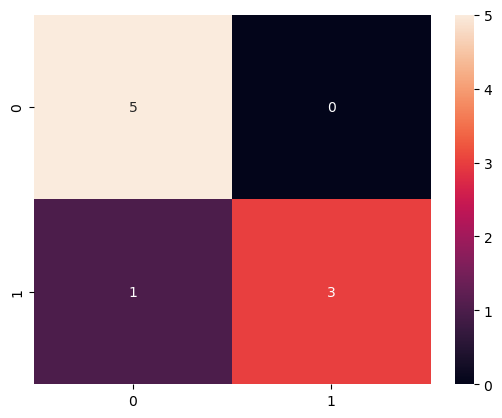

In [87]:
import seaborn as sn
sn.heatmap(cm, annot=True)

In [83]:
class_dictionary

{'lionel_messi': 0, 'virat_kohli': 1}

# Now lets save the trained model

In [89]:
import joblib

joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

# Also lets save class dictionary

In [92]:
import json

with open("class_dictionary.json", 'w') as f:
    f.write(json.dumps(class_dictionary))